# Proyecto Parcial 1 **Machine Learning**
Elige un problema, y por ende un conjunto de datos,  en el que puedas utilizar el método de inferencia de parámteros utilizando el método de inferencia bayesiana y las cadenas de markov.
* El número de parámetros a estimar debe ser mayor a 2
* El modelo debe ser diferente a una linea recta
* El likelihood se recomienda sea Gaussiano
* Utiliza priors planos

In [2]:
# Primero se instalan las librerías que necesitaremos:
!pip install corner
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.3 MB/s eta 0:00:00


In [3]:
# Impor las librerías
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
from google.colab import drive

Trataremos con datos sobre cómo se propaga una onda de agua al caer una piedra en ella, dentro de un recipiente.

In [50]:
# Cargar los datos
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Data/data_p.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
#Asignar los datos a las variables
Y = data['y']
X = data['x0']

Ahora, hay que graficar los datos para observar su distribución.

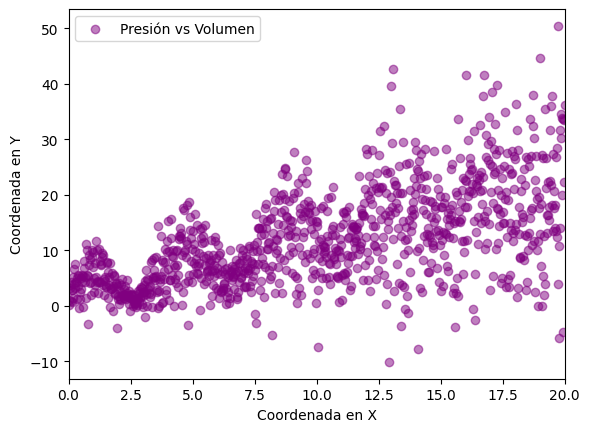

In [53]:
plt.figure()
plt.scatter(X, Y, label='Presión vs Volumen', color = 'purple', alpha=0.5)
plt.xlabel('Coordenada en X')
plt.ylabel('Coordenada en Y')
plt.xlim(0,20)
plt.legend()
plt.show()

El modelo que siguen los datos viene dado por la ecuación:

$Y = X+b+Asin(BX+c)+Asin\left(BX+C+\dfrac{\pi}{2}\right)$

In [54]:
# Definir el modelo que siguen los datos
def modelo(X, b, A, B, C):
  return X + b + A * np.sin(B * X + C) + A * np.sin(B * X + C + np.pi / 2)

In [55]:
# Definir el log del likelihood
def lnlike (params, X, desv, Y):
  b, A, B, C = params
  Y_m = modelo (X, b, A, B, C)
  log = - 1 / 2 * np.sum((Y - Y_m) ** 2 / desv ** 2)
  return log

In [80]:
# Definir el log del prior
def lnprior(params):
    b, A, B, C = params

    # Verificar si los parámetros están dentro de los límites
    if (-10 < A < 10) and (-10 < B < 10) and (0 <= C < 10) and (-10 < b < 10):
        return 0.0  # Si están dentro de los límites, el prior es 0 (uniforme)
    else:
        return -np.inf  # Si están fuera de los límites, el prior es -infinito (probabilidad cero)

In [81]:
# Definir el log de la probabilidad posterior
def lnposterior(params, X, Y, desv):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, X, Y, desv)

Ahora, se deben definir los valores iniciales y la configuración del método MCMC.

In [82]:
np.random.seed(0)

# Configuración MCMC
cadenas = 150
dim = 4
pasos = 30000

In [83]:
# Definir los valores iniciales de los parámetros
# [b, A, B, C]
coeficientes_ini = [0, -1, 1, 1.5]

In [84]:
# Iniciar los caminantes de MCMC
posicion_ini = coeficientes_ini + 1e-4 * np.random.randn(cadenas, dim)

In [85]:
# Ahora, configurar el sampler de la librería emcee
sampler = emcee.EnsembleSampler(cadenas, dim, lnposterior, args=(X, Y, 0.1))

In [ ]:
# Se ejecuta el método MCMC
sampler.run_mcmc(posicion_ini, pasos, progress=True)

 81%|████████▏ | 24418/30000 [2:05:19<27:30,  3.38it/s]

Ahora, para visualizar el resultado de aplicar el método, utilizamos la librería corner.

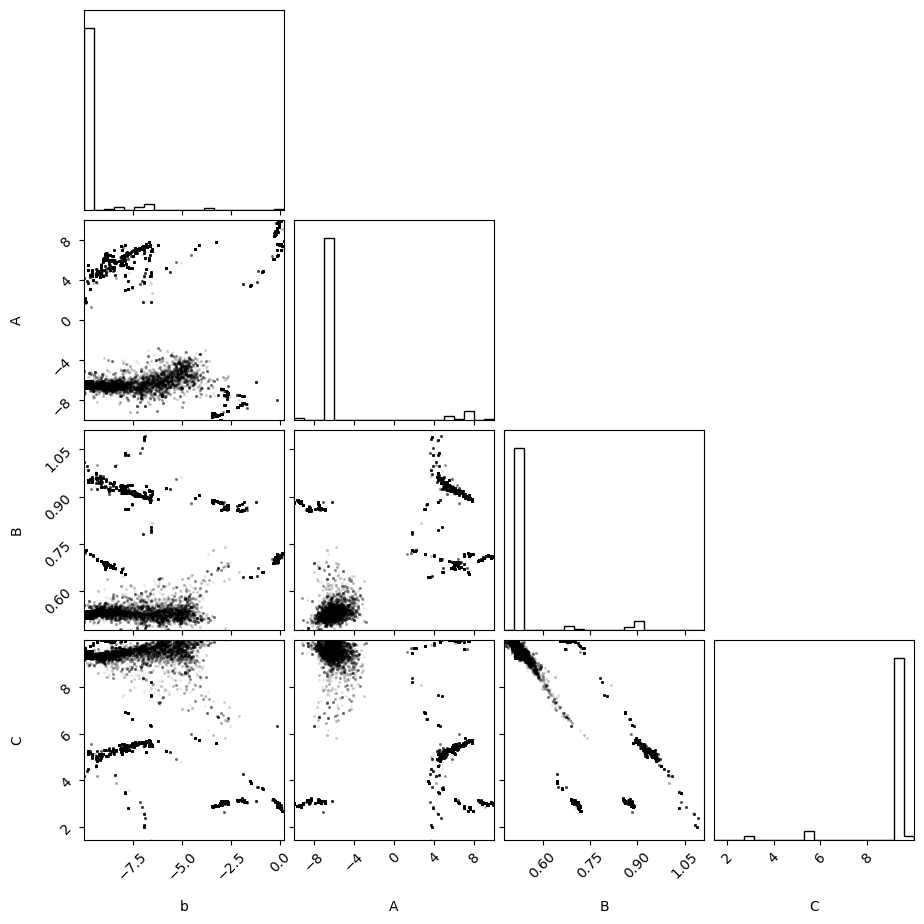

In [87]:
# Visualizar los resultados de MCMC, descartando los primeros 100 y con un sample cada 3 puntos
samples = sampler.get_chain(discard=100, thin=1, flat=True)
nombres = ["b", "A", "B", "C", "desv"]

# Visualizar los datos reales
fig = corner.corner(samples, labels = nombres, shot_titles = True)

Ahora, vamos a graficar las diferentes cadenas con sus respectivos pasos.

In [88]:
# Se deben de cargar las muestras de las cadenas de Markov
samples = sampler.get_chain()

IndexError: ignored

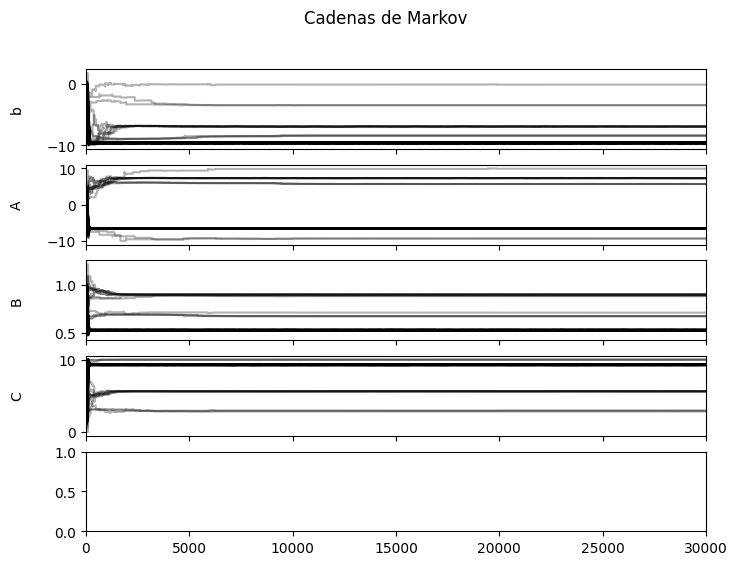

In [92]:
fig, axes = plt.subplots(len(nombres), figsize=(8, 6), sharex=True)
fig.suptitle("Cadenas de Markov")

# Graficar cada cadena de Markov
for i in range(len(nombres)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(nombres[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Etiqueta el eje x en la parte inferior
axes[-1].set_xlabel("Paso")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Finalmente, vamos a graficar los datos obtenidos con el método MCMC.

In [76]:
# Primero, se calcula el valor promedio de las muestras para obtener los valores estimados de cada parámetros
valores_est = np.mean(samples, axis=(0, 1))
b_est, A_est, B_est, C_est = valores_est

In [77]:
# Crear un conjunto volúmenes para la regresión
X_regr = np.linspace(X.min(), X.max(), 1000)

# Calcular los valores estimados de la regresión
Y_regr = modelo(X_regr, b_est, A_est, B_est, C_est)

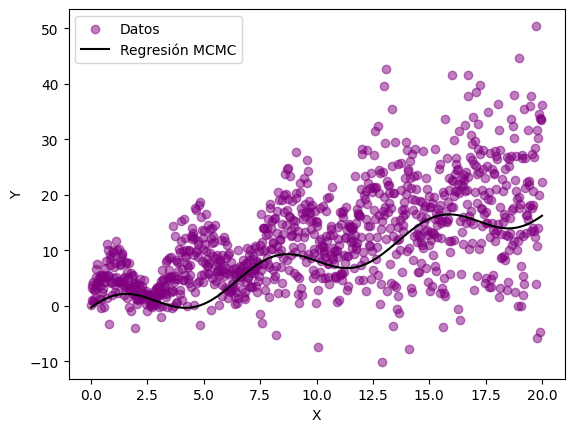

In [79]:
# Grafica los datos observados y la regresión
plt.figure()
plt.scatter(X, Y, label='Datos', color = 'purple', alpha=0.5)
plt.plot(X_regr, Y_regr, 'k', label='Regresión MCMC')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()